In [54]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats

In [55]:
'''
ID : 집을 구분하는 번호

date : 집을 구매한 날짜
- ISO 8601 표기법으로 날짜 데이터만 있고 시간 데이터는 없다.
- date의 경우 yyyy-mm-dd + T000000의 형태로 필요한 부분은 앞의 8자리, 뒷 6자리는 드랍해야함.
'''

'''
price : 집의 가격(Target variable)

bedrooms : 침실의 수

bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
-이런 이유로 소수점이 있음.

sqft_living : 주거 공간의 평방 피트(면적)
- 1평방피트는 약 0.0281평이고, 1평은 약 35.6평방피트
- 다 평방피트라서 단위면적이라고 생각하면 될 거 같음.

sqft_lot : 부지의 평방 피트(면적)

floors : 집의 층 수

waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)

view : 집이 얼마나 좋아 보이는지의 정도

condition : 집의 전반적인 상태

grade : King County grading 시스템 기준으로 매긴 집의 등급

sqft_above : 지하실을 제외한 평방 피트(면적)

sqft_basement : 지하실의 평방 피트(면적)

yr_built : 지어진 년도

yr_renovated : 집을 리모델링한 년도
- yr_renovated의 경우 0의 값이 보이는데, 0년도에 리모델링이 되었다는 의미가 아니라 리모델링을 하지 않았다는 의미

zipcode : 우편번호

lat : 위도

long : 경도

sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 리모델링했다면, 변화가 있을 수 있음)

sqft_living 과 sqft_living15처럼 비슷한 값이 보임. 
둘은 15년도를 기준으로 크기 계산의 기준에 따라 다른 값을 보임.
- 전처리 유의

sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 리모델링했다면, 변화가 있을 수 있음)
--------------------------------------------------
EDA 전에 생각해 볼것

월별, 계절별, 연도별 집값의 변화를 시각화 // 시간 흐름, 월초 월말에 따른 집값 변동

건축/리모델링 연도(yr_built, yr_renovated) 가공

- yr_built와 price의 산점도

- age: sale_year - yr_built

- age_after_renovation: 리모델링이 되었다면, sale_year - yr_renovated
effective_year: yr_renovated가 0이 아니면 yr_renovated를, 0이면 

- yr_built를 사용. 즉, 가장 최근에 공사한 연도를 나타내는 통합 변수

- sqft_living과 sqft_lot의 관계
주거면적이 같다고 대지면적이 같은지?

sqft_basement가 0인 집과 0이 아닌 집의 가격 차이도 클 것

has_basement: sqft_basement > 0 이면 1, 아니면 0 

lot_to_living_ratio: sqft_lot / sqft_living (주거 면적 대비 대지 면적 비율)

living_to_room_ratio: sqft_living / (bedrooms + bathrooms) (방 개수 대비 면적, 0으로 나누는 경우 주의)

basement_ratio: sqft_basement / sqft_living (전체 면적 중 지하실 비율)

floor_area: sqft_living / floors (층당 평균 면적)

zipcode별 평균 가격을 계산하고 시각화

zipcode_price_mean, zipcode_price_median: 각 zipcode 그룹의 평균/중앙 집값. (Target Encoding) 

location_cluster: lat, long을 이용해 K-Means 같은 군집화 알고리즘을 적용하여 지역을 몇 개의 그룹으로 나눔. 
zipcode보다 더 세분화된 지역 정보

distance_to_center: 특정 중심지(e.g., 시애틀 시내 중심)의 위도/경도를 설정하고, 각 집으로부터의 유클리드 거리를 계산.

EDA 관점: sqft_living과 sqft_living15를 비교하는 산점도

living_vs_neighbor_ratio: sqft_living / sqft_living15 (주변 집 대비 우리 집 면적 비율)

lot_vs_neighbor_ratio: sqft_lot / sqft_lot15 (주변 집 대비 우리 집 대지 비율)

EDA 관점: bedrooms가 33개 같은 비정상적인 값(이상치, Outlier)이 있는지 확인.
bedrooms가 0인데 가격이 높은 경우는 스튜디오 형태의 고급 주택일 수 있습니다.

집값은 결국에는 지역이 짱
침실에 100개던 1000개던 
비싼 지역이 집값이 비싸다.

'''
pass

In [56]:
data = pd.read_csv("kaggle-kakr-housing-data/data/train.csv") 
print(data.info())

test = pd.read_csv("kaggle-kakr-housing-data/data/test.csv")
print(test.info())

sub = pd.read_csv('kaggle-kakr-housing-data/data/sample_submission.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

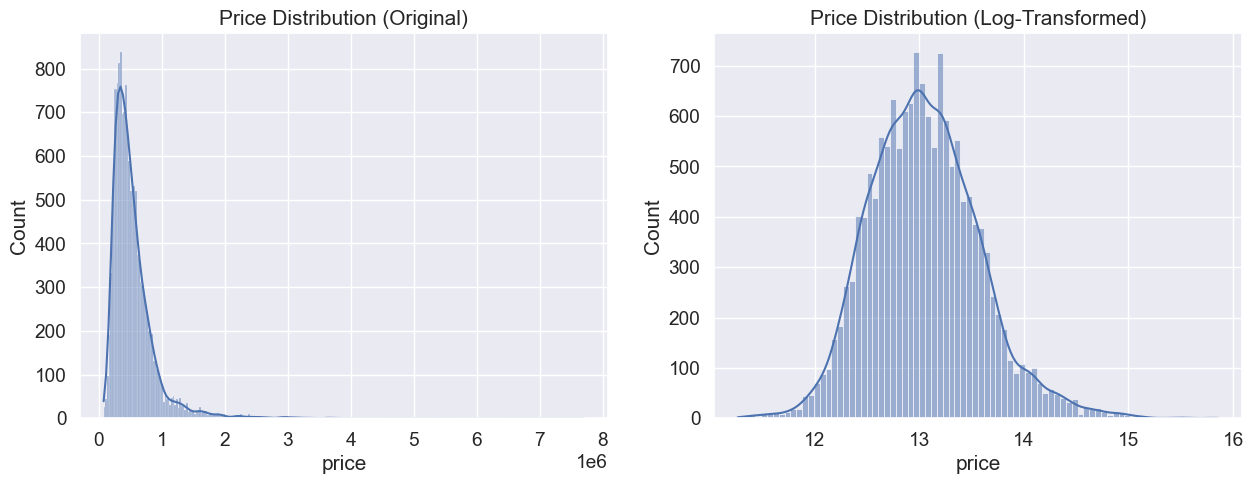

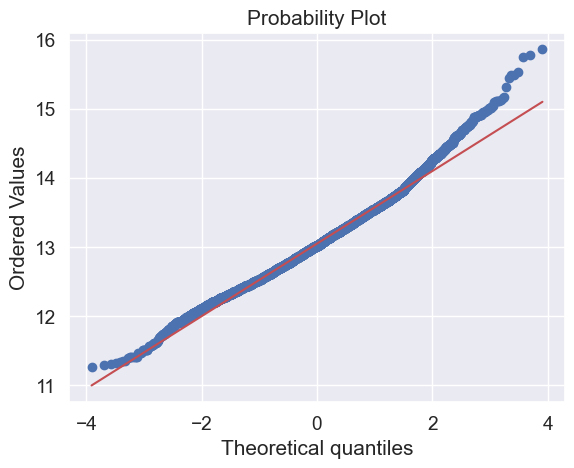

Skewness: 4.290252
Kurtosis: 40.154919


'\ntarget 변수인 price가\n오른쪽으로 치우쳐 있고,\n첨도가 정규분포는 3을 가지지만\n40을 가지고 있기 때문에 로그스케일을 해야한다. \n'

In [57]:
train_df = pd.DataFrame(data)
# --- price 분포 확인 ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(train_df['price'], kde=True, ax=axes[0])
axes[0].set_title('Price Distribution (Original)')

# --- price 로그 변환 ---
# np.log1p는 log(1+x)를 계산하여 x가 0일 때도 안전하게 변환합니다.
train_df['price'] = np.log1p(train_df['price'])

sns.histplot(train_df['price'], kde=True, ax=axes[1])
axes[1].set_title('Price Distribution (Log-Transformed)')
plt.show()

# QQ-Plot으로 정규분포에 얼마나 가까워졌는지 확인
stats.probplot(train_df['price'], plot=plt)
plt.show()

print("Skewness: %f" % data['price'].skew()) # 왜도
print("Kurtosis: %f" % data['price'].kurt()) # 첨도

'''
target 변수인 price가
오른쪽으로 치우쳐 있고,
첨도가 정규분포는 3을 가지지만
40을 가지고 있기 때문에 로그스케일을 해야한다. 
'''

In [58]:
# --- 날짜 데이터 처리 ---
train_df['date'] = train_df['date'].apply(lambda x: x[:8]) # 'YYYYMMDD' 형식으로 정리
train_df['yr_sold'] = train_df['date'].str[:4].astype(int)
train_df['month_sold'] = train_df['date'].str[4:6].astype(int)

# --- 파생 변수 생성 ---
# 1. 집의 나이
train_df['age'] = train_df['yr_sold'] - train_df['yr_built']

# 2. 리모델링 여부 (리모델링 연도가 0이 아니면 1, 맞으면 0)
train_df['is_renovated'] = (train_df['yr_renovated'] != 0).astype(int)

# 3. 주거 면적 대비 대지 면적 비율
# sqft_living이 0인 경우를 대비하여 작은 값(1e-6)을 더해줌
train_df['lot_to_living_ratio'] = train_df['sqft_lot'] / (train_df['sqft_living'] + 1e-6)

# --- 불필요한 변수 제거 ---
# id, 원본 날짜, 파생 변수 생성에 사용된 기존 변수 등
drop_cols = ['id', 'date', 'yr_built', 'yr_renovated']
train_df = train_df.drop(columns=drop_cols)

print("피처 엔지니어링 완료!")
train_df.head()

피처 엔지니어링 완료!


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,age,is_renovated,lot_to_living_ratio
0,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,...,98178,47.5112,-122.257,1340,5650,2014,10,59,0,4.788136
1,12.100718,2,1.00,770,10000,1.0,0,0,3,6,...,98028,47.7379,-122.233,2720,8062,2015,2,82,0,12.987013
2,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,...,98074,47.6168,-122.045,1800,7503,2015,2,28,0,4.809524
3,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,...,98003,47.3097,-122.327,2238,6819,2014,6,19,0,3.976093
4,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,...,98198,47.4095,-122.315,1650,9711,2015,1,52,0,9.161321


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


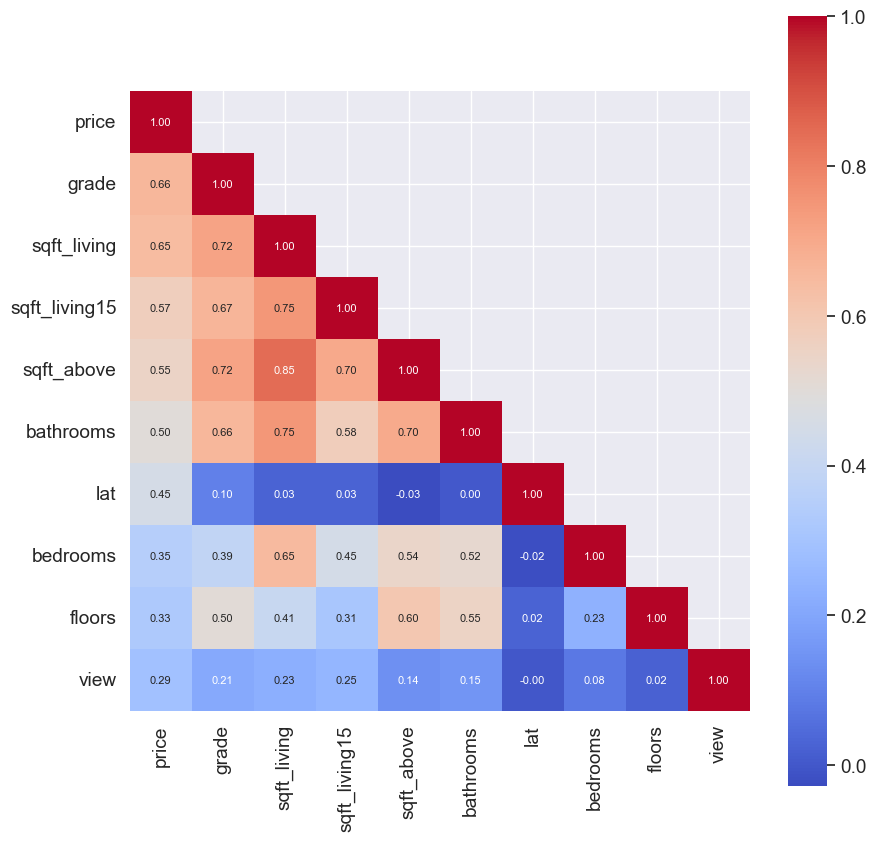

'\n목적변수와 상관도가 높은 변수는 집의 등급 - 주거공간의 크기 - 전체 크기순이고 \n재미있게 lat이라는 위도 값이 들어있습니다. 위도가 증가함에 따라 가격이 왜 증가하는지 ? \n'

In [59]:
cor_abs = abs(train_df.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sc.stats.spearmanr(train_df[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)

mask = np.triu(np.ones_like(cor, dtype=bool), k=1)


# 2. 히트맵 시각화 (mask 인자 추가)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)

# mask=mask를 추가하여 히트맵의 위쪽 부분을 가립니다.
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8},
            xticklabels=cor_cols.values, yticklabels=cor_cols.values,
            mask=mask, cmap='coolwarm') # cmap 추가로 색상 변경

plt.show()

'''
목적변수와 상관도가 높은 변수는 집의 등급 - 주거공간의 크기 - 전체 크기순이고 
재미있게 lat이라는 위도 값이 들어있습니다. 위도가 증가함에 따라 가격이 왜 증가하는지 ? 
'''

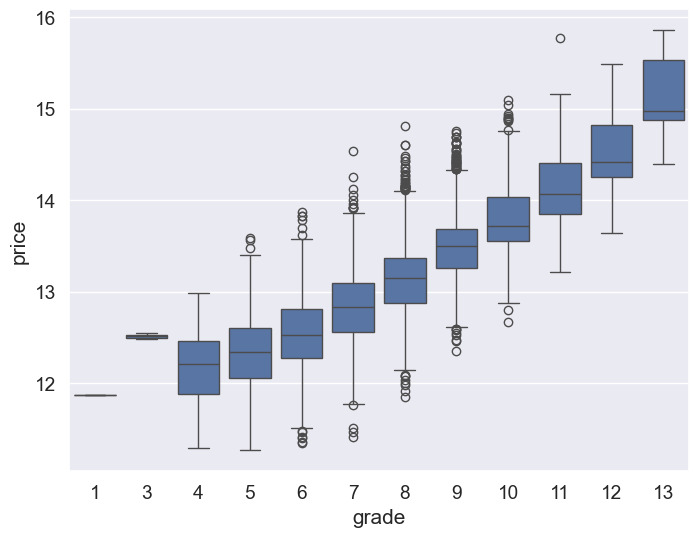

'\ngrade의 경우 "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, \n11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." 라고 합니다.\n\n집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전박적으로 상승곡선의 형태도 보이고 있습니다. 하지만\n\n등급 3의 경우 값이 큰 이유\n등급 7,8,9에서 이상치가 많은 이유\n등급 8과 11에서 차이가 큰 이상치가 나타나는 이유\n위의 3가지는 좀 더 자세히 살펴봐야 합니다. \n'

In [60]:
data = pd.concat([train_df['price'], train_df['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='grade', y="price", data=data)
plt.show()


'''
grade의 경우 "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 
11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." 라고 합니다.

집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전박적으로 상승곡선의 형태도 보이고 있습니다. 하지만

등급 3의 경우 값이 큰 이유
등급 7,8,9에서 이상치가 많은 이유
등급 8과 11에서 차이가 큰 이상치가 나타나는 이유
위의 3가지는 좀 더 자세히 살펴봐야 합니다. 
'''

In [61]:
# --- 피처(X)와 타겟(y) 분리 ---
# price는 로그 변환된 상태
y = train_df['price']
X = train_df.drop(columns=['price'])

# --- 학습용/검증용 데이터 분할 ---
# 80%는 학습용, 20%는 검증용으로 사용
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")

X_train shape: (12028, 21), X_val shape: (3007, 21)
y_train shape: (12028,), y_val shape: (3007,)


In [62]:
# --- 베이스라인 모델 학습 ---
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# --- 예측 및 평가 ---
# y_val은 로그 스케일이므로, 모델 예측값도 로그 스케일
baseline_preds_log = baseline_model.predict(X_val)

# 평가는 원래 스케일(달러)로 되돌려서 수행해야 의미를 알 수 있음
y_val_original = np.expm1(y_val)
baseline_preds_original = np.expm1(baseline_preds_log)

# RMSE (Root Mean Squared Error) 계산
baseline_rmse = np.sqrt(mean_squared_error(y_val_original, baseline_preds_original))

print(f"--- Baseline Model (Linear Regression) ---")
print(f"Validation RMSE: ${baseline_rmse:,.2f}")

--- Baseline Model (Linear Regression) ---
Validation RMSE: $175,557.69


In [85]:
# --- LightGBM 하이퍼파라미터 설정 ---
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 2000,
    'learning_rate': 0.03382400153482012,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 3.507321036196403e-08,
    'lambda_l2': 0.0008341091090823973,
    'num_leaves': 46,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}
'''
 {'learning_rate': 0.03382400153482012, 'num_leaves': 46, 'max_depth': 12, 
 'min_child_samples': 28, 'subsample': 0.894705145715552, 
 'colsample_bytree': 0.633307270906186, 'lambda_l1': 3.507321036196403e-08, 
 'lambda_l2': 0.0008341091090823973} 
'''
# --- LightGBM 모델 학습 ---
lgb_model = lgb.LGBMRegressor(**params)

# 조기 종료(Early Stopping)를 사용하여 최적의 시점에서 학습을 멈춤
callbacks = [lgb.early_stopping(100, verbose=False)]

lgb_model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=callbacks)

# --- 예측 및 평가 ---
lgb_preds_log = lgb_model.predict(X_val)

# 원래 스케일로 변환
lgb_preds_original = np.expm1(lgb_preds_log)

lgb_rmse = np.sqrt(mean_squared_error(y_val_original, lgb_preds_original))

print(f"--- Advanced Model (LightGBM) ---")
print(f"Validation RMSE: ${lgb_rmse:,.2f}")

--- Advanced Model (LightGBM) ---
Validation RMSE: $115,712.62


In [86]:
results = pd.DataFrame({
    'Model': ['Linear Regression (Baseline)', 'LightGBM (Advanced)'],
    'Validation RMSE': [baseline_rmse, lgb_rmse]
})

results['RMSE'] = results['Validation RMSE'].apply(lambda x: f"${x:,.2f}")
print(results[['Model', 'RMSE']])

                          Model         RMSE
0  Linear Regression (Baseline)  $175,557.69
1           LightGBM (Advanced)  $115,712.62


In [87]:
test_df = pd.read_csv("kaggle-kakr-housing-data/data/test.csv")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [88]:
test_ids = test_df['id']
test_df['date'] = test_df['date'].apply(lambda x: x[:8])
test_df['yr_sold'] = test_df['date'].str[:4].astype(int)
test_df['month_sold'] = test_df['date'].str[4:6].astype(int)

# 2. 파생 변수 생성
test_df['age'] = test_df['yr_sold'] - test_df['yr_built']
test_df['is_renovated'] = (test_df['yr_renovated'] != 0).astype(int)
test_df['lot_to_living_ratio'] = test_df['sqft_lot'] / (test_df['sqft_living'] + 1e-6)

In [89]:
drop_cols = ['id', 'date', 'yr_built', 'yr_renovated']
test_df = test_df.drop(columns=drop_cols)

In [90]:
train_features = X_train.columns
X_test = test_df[train_features]

In [91]:
print("\n--- Making Predictions with LightGBM Model ---")

# 1. LightGBM 모델로 예측 수행 (결과는 로그 스케일)
lgb_test_preds_log = lgb_model.predict(X_test)

# 2. 최종 예측값을 원래 스케일(달러)로 변환
final_predictions = np.expm1(lgb_test_preds_log)

# 3. 혹시 모를 음수 예측값을 0으로 처리 (안전장치)
final_predictions[final_predictions < 0] = 0

print("Prediction and final transformation complete.")


--- Making Predictions with LightGBM Model ---
Prediction and final transformation complete.


In [92]:
submission_df = pd.DataFrame({
    'id': test_ids,
    'price': final_predictions
})

# CSV 파일로 저장합니다. index=False는 필수입니다!
submission_df.to_csv('submission_lgbm.csv', index=False)

print("\n--- Submission file created successfully! ---")
print("File name: submission_lgbm.csv")
print("Top 5 rows of the submission file:")
print(submission_df.head())


--- Submission file created successfully! ---
File name: submission_lgbm.csv
Top 5 rows of the submission file:
      id         price
0  15035  5.109275e+05
1  15036  4.874796e+05
2  15037  1.372973e+06
3  15038  2.828438e+05
4  15039  3.287512e+05
